# Polish Lotto Extraction Analysis
This notebook contains code to fetch lotto extraction data, perform frequency analysis, and visualize the results with a color gradient.

NOTE: Please download [here](http://www.mbnet.com.pl/wyniki.htm) the txt file for the game you want, save it in the repository main directory with the name lotto.txt, miniLotto.txt, lottoPlus.txt  

## Importing Required Libraries

In [122]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations
from collections import Counter
import requests
from datetime import datetime

## Download latest txt files

In [123]:
# Define names
LOTTO = "lotto.txt"
LOTTOPLUS = "lottoPlus.txt"
MINILOTTO = "miniLotto.txt"

# Define the URLs and corresponding file names
files = {
    "http://www.mbnet.com.pl/dl.txt": LOTTO,
    "http://www.mbnet.com.pl/dl_plus.txt": LOTTOPLUS,
    "http://www.mbnet.com.pl/el.txt": MINILOTTO
}

# Iterate over the dictionary and download each file
for url, filename in files.items():
    # Send a GET request to download the file
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Write the content to the respective file
        with open(filename, "wb") as file:
            file.write(response.content)
        print(f"File downloaded and renamed to '{filename}'.")
    else:
        print(f"Failed to download the file from {url}. Status code:", response.status_code)

File downloaded and renamed to 'lotto.txt'.
File downloaded and renamed to 'lottoPlus.txt'.
File downloaded and renamed to 'miniLotto.txt'.


## Choose the file with the lotto number list

In [124]:
# Path to the txt file
file_path = MINILOTTO


## Function to Fetch Lotto Data

In [125]:
def read_lotto_data_from_txt(file_path):
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()

        lotto_data = {}
        for line in lines:
            # Splitting by space after the period to separate the draw number, date, and numbers
            parts = line.split('. ', 1)
            play_number = int(parts[0])

            # Splitting by space to separate the date and numbers
            date_and_numbers = parts[1].split(' ', 1)
            formatted_date = date_and_numbers[0]
            numbers = [int(num) for num in date_and_numbers[1].strip().split(',')]

            lotto_data[play_number] = {
                'date': formatted_date,
                'gametype': 'Minilotto',
                'numbers': numbers  # Now numbers are stored as integers
            }

        return lotto_data

    except Exception as e:
        print(f'Error reading data: {e}')

# Fetching lotto results from the txt file
lotto_results = read_lotto_data_from_txt(file_path)

## Function to filter by data range

In [126]:
def filter_lotto_results_by_date(lotto_results, start_date, end_date):
    """
    Filters the lotto results to include only those within the specified date range.

    :param lotto_results: Dictionary of lotto results.
    :param start_date: String of start date in 'dd.mm.yyyy' format.
    :param end_date: String of end date in 'dd.mm.yyyy' format.
    :return: Filtered dictionary of lotto results.
    """
    # Convert start_date and end_date to datetime objects
    start_date = datetime.strptime(start_date, "%d.%m.%Y")
    end_date = datetime.strptime(end_date, "%d.%m.%Y")

    # Filter the results
    filtered_results = {}
    for play_number, play_data in lotto_results.items():
        play_date = datetime.strptime(play_data['date'], "%d.%m.%Y")
        if start_date <= play_date <= end_date:
            filtered_results[play_number] = play_data

    return filtered_results


## Select data range

In [127]:
# Example usage
start_date = "01.01.2024"
end_date = "30.12.2024"
lotto_results = filter_lotto_results_by_date(lotto_results, start_date, end_date)

# Now, filtered_lotto_results contains only the plays between the start_date and end_date

## Total draws in the selected period

In [128]:
total_draws = len(lotto_results)
print(f"{total_draws} draws from {start_date} to {end_date}")

241 draws from 01.01.2024 to 30.12.2024


## Last 10 draws

In [129]:
# Displaying the last 10 (newest) results from lotto_results dictionary
last_10_plays = sorted(lotto_results.keys())[-10:]
for play_number in last_10_plays:
    result = lotto_results[play_number]
    print(f"Play Number: {play_number}, Date: {result['date']}, Numbers: {result['numbers']}")


Play Number: 6558, Date: 20.08.2024, Numbers: [6, 7, 11, 14, 26]
Play Number: 6559, Date: 21.08.2024, Numbers: [3, 9, 15, 30, 41]
Play Number: 6560, Date: 22.08.2024, Numbers: [1, 11, 32, 41, 42]
Play Number: 6561, Date: 23.08.2024, Numbers: [7, 18, 20, 29, 41]
Play Number: 6562, Date: 24.08.2024, Numbers: [7, 15, 24, 35, 36]
Play Number: 6563, Date: 25.08.2024, Numbers: [7, 13, 37, 39, 41]
Play Number: 6564, Date: 26.08.2024, Numbers: [2, 9, 19, 29, 41]
Play Number: 6565, Date: 27.08.2024, Numbers: [12, 25, 32, 33, 34]
Play Number: 6566, Date: 28.08.2024, Numbers: [12, 22, 25, 29, 35]
Play Number: 6567, Date: 29.08.2024, Numbers: [15, 21, 26, 30, 41]


## Frequency Analysis

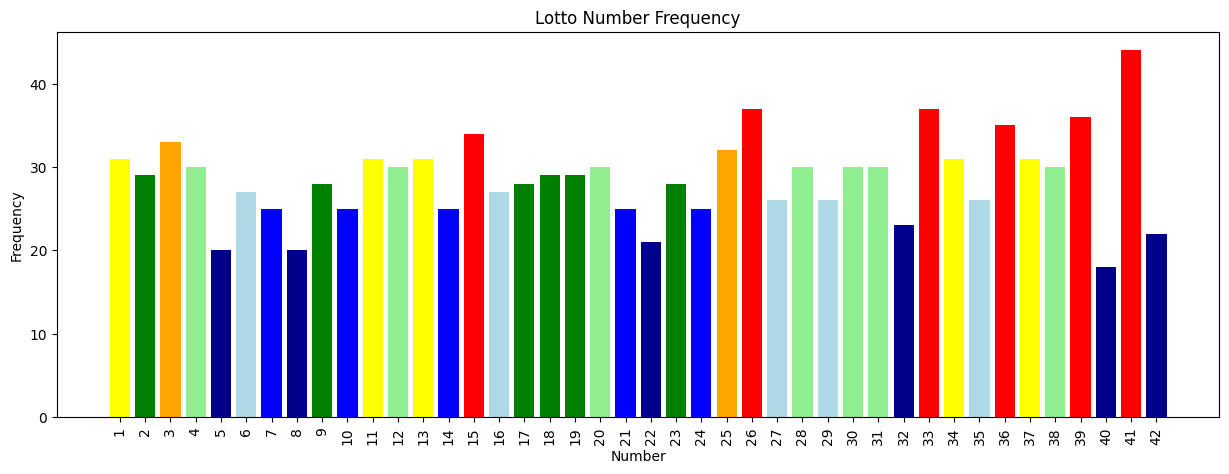

In [130]:
def frequency_analysis(lotto_data):
    numbers = []
    for play in lotto_data.values():
        numbers.extend(play['numbers'])
    return Counter(numbers)

number_frequency = frequency_analysis(lotto_results)
sorted_numbers = sorted(number_frequency.items(), key=lambda x: x[1])
numbers, frequencies = zip(*sorted_numbers)

# Define nine thresholds for the deciles
thresholds = np.quantile(frequencies, np.linspace(1/8, 7/8, 7))

# Define 10 colors for each decile
octile_colors = [
    'darkblue',    # Least frequent - coldest
    'blue',
    'lightblue',
    'green',
    'lightgreen',
    'yellow',
    'orange',
    'red'        # Most frequent - hottest
]

# Assign a color based on which decile each frequency falls into
colors = []
for freq in frequencies:
    for i, threshold in enumerate(thresholds):
        if freq <= threshold:
            colors.append(octile_colors[i])
            break
    else:
        colors.append(octile_colors[-1])  # Assign the last color to the top decile

# Plotting the results with the assigned colors
plt.figure(figsize=(15, 5))
plt.bar(numbers, frequencies, color=colors)
plt.xlabel('Number')
plt.ylabel('Frequency')
plt.title('Lotto Number Frequency')
plt.xticks(numbers, rotation=90)
plt.show()

## Trend Analysis
This analysis examines how the frequency of specific numbers or combinations changes over time.

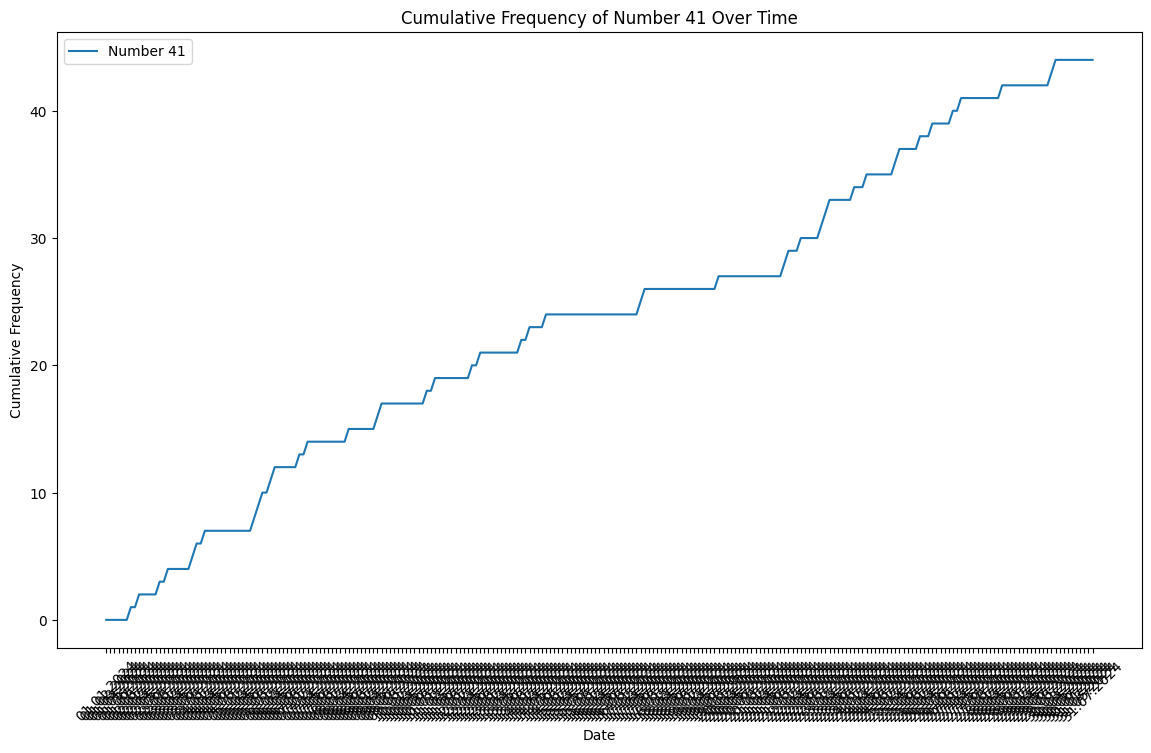

In [131]:
import matplotlib.pyplot as plt

def trend_analysis(lotto_data, target_number):
    dates = []
    occurrences = []
    count = 0
    for play in sorted(lotto_data.values(), key=lambda x: x['date']):
        dates.append(play['date'])
        if target_number in play['numbers']:
            count += 1
        occurrences.append(count)

    plt.figure(figsize=(14, 8))  # Increase figure size for better readability
    plt.plot(dates, occurrences, label=f'Number {target_number}')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Frequency')
    plt.title(f'Cumulative Frequency of Number {target_number} Over Time')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

# Example usage for number 7
trend_analysis(lotto_results, target_number=41)



## Chi-Square Test
This statistical test can be used to determine if the frequency distribution of numbers is uniform, as would be expected in a random draw.

In [132]:
!pip install scipy
from scipy.stats import chi2_contingency

def chi_square_test(lotto_data):
    observed_freq = list(frequency_analysis(lotto_data).values())
    expected_freq = [sum(observed_freq) / len(observed_freq)] * len(observed_freq)
    
    chi2_stat, p_value = chi2_contingency([observed_freq, expected_freq])[:2]
    
    print(f"Chi-Square Statistic: {chi2_stat}")
    print(f"P-Value: {p_value}")
    if p_value < 0.05:
        print("Reject the null hypothesis: The distribution is not uniform.")
    else:
        print("Fail to reject the null hypothesis: The distribution is uniform.")

# Example usage
chi_square_test(lotto_results)


P-Value: 0.9991024256345259
Fail to reject the null hypothesis: The distribution is uniform.




[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Heatmap Visualization
This visualization method uses a heatmap to show the frequency of numbers.

In [134]:
!pip install seaborn
import seaborn as sns

def heatmap_visualization(lotto_data):
    number_frequency = frequency_analysis(lotto_data)
    numbers, frequencies = zip(*sorted(number_frequency.items()))

    plt.figure(figsize=(10, 8))
    sns.heatmap([frequencies], annot=numbers, cmap="YlGnBu", cbar=True, fmt="d")
    plt.title('Heatmap of Lotto Number Frequencies')
    plt.show()

# Example usage
heatmap_visualization(lotto_results)


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)



[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


ValueError: `data` and `annot` must have same shape.

<Figure size 1000x800 with 0 Axes>

## Print the five more and less probable numbers

In [106]:
# Sorting the numbers by frequency in descending order
most_frequent_numbers = sorted(number_frequency, key=number_frequency.get, reverse=True)[:5]

# Sorting the numbers by frequency in ascending order
least_frequent_numbers = sorted(number_frequency, key=number_frequency.get)[:5]

print("5 Most Probable Numbers:", most_frequent_numbers)
print("5 Least Probable Numbers:", least_frequent_numbers)

5 Most Probable Numbers: [41, 33, 26, 39, 36]
5 Least Probable Numbers: [40, 8, 5, 22, 42]


## Verifying if the Most or Least Probable Sets of Five Numbers Have Been Previously Drawn

In [107]:
def check_occurrence(lotto_data, numbers_set):
    occurrences = []
    for play_number, play_data in lotto_data.items():
        if set(play_data['numbers']) == numbers_set:
            occurrences.append((play_number, play_data['date']))
    return occurrences

# Most and least probable numbers
most_probable_numbers = set(most_frequent_numbers)
least_probable_numbers = set(least_frequent_numbers)

# Check if these sets ever occurred in the history
most_probable_occurrences = check_occurrence(lotto_results, most_probable_numbers)
least_probable_occurrences = check_occurrence(lotto_results, least_probable_numbers)

print("Occurrences of Most Probable Numbers:")
if most_probable_occurrences:
    for play_number, date in most_probable_occurrences:
        print(f"Play Number: {play_number}, Date: {date}")
else:
    print("None")

print("\nOccurrences of Least Probable Numbers:")
if least_probable_occurrences:
    for play_number, date in least_probable_occurrences:
        print(f"Play Number: {play_number}, Date: {date}")
else:
    print("None")


Occurrences of Most Probable Numbers:
None

Occurrences of Least Probable Numbers:
None


## Comprehensive Analysis of Lotto Number Combinations: Pairs, Triplets, and Quadruplets

In [108]:
def analyze_combinations(lotto_data, combination_size=2):
    """
    Analyzes the frequency of combinations (like pairs, triplets, quadruplets) in the lotto data.

    :param lotto_data: Dictionary of lotto results.
    :param combination_size: Size of the combinations to analyze (2 for pairs, 3 for triplets, 4 for quadruplets).
    :return: Counter object with the frequency of each combination.
    """
    all_combinations = []

    # Iterate through each draw and find combinations
    for play_data in lotto_data.values():
        numbers = play_data['numbers']
        for combo in combinations(numbers, combination_size):
            all_combinations.append(tuple(sorted(combo)))

    return Counter(all_combinations)

# Example usage
for combination_size in [2, 3, 4]:  # For pairs, triplets, and quadruplets
    print(f"\nAnalyzing {combination_size}-number combinations:")
    combinations_frequency = analyze_combinations(lotto_results, combination_size)

    # Display the most common combinations
    for combo, frequency in combinations_frequency.most_common(10):
        print(f"Combination: {combo}, Frequency: {frequency}")



Analyzing 2-number combinations:
Combination: (25, 41), Frequency: 8
Combination: (33, 37), Frequency: 8
Combination: (1, 41), Frequency: 8
Combination: (26, 31), Frequency: 8
Combination: (3, 29), Frequency: 8
Combination: (28, 33), Frequency: 7
Combination: (16, 30), Frequency: 7
Combination: (13, 37), Frequency: 7
Combination: (15, 41), Frequency: 7
Combination: (23, 34), Frequency: 7

Analyzing 3-number combinations:
Combination: (8, 17, 25), Frequency: 3
Combination: (25, 28, 41), Frequency: 3
Combination: (13, 22, 41), Frequency: 3
Combination: (1, 6, 37), Frequency: 3
Combination: (4, 19, 39), Frequency: 3
Combination: (3, 16, 30), Frequency: 3
Combination: (2, 17, 19), Frequency: 3
Combination: (27, 35, 38), Frequency: 3
Combination: (7, 18, 20), Frequency: 3
Combination: (26, 31, 33), Frequency: 3

Analyzing 4-number combinations:
Combination: (4, 16, 28, 33), Frequency: 2
Combination: (3, 13, 16, 30), Frequency: 2
Combination: (7, 15, 41, 42), Frequency: 2
Combination: (25, 

## Detailed Analysis of Lotto Number Distributions and Trends

Change bin size for broader view or more granularity

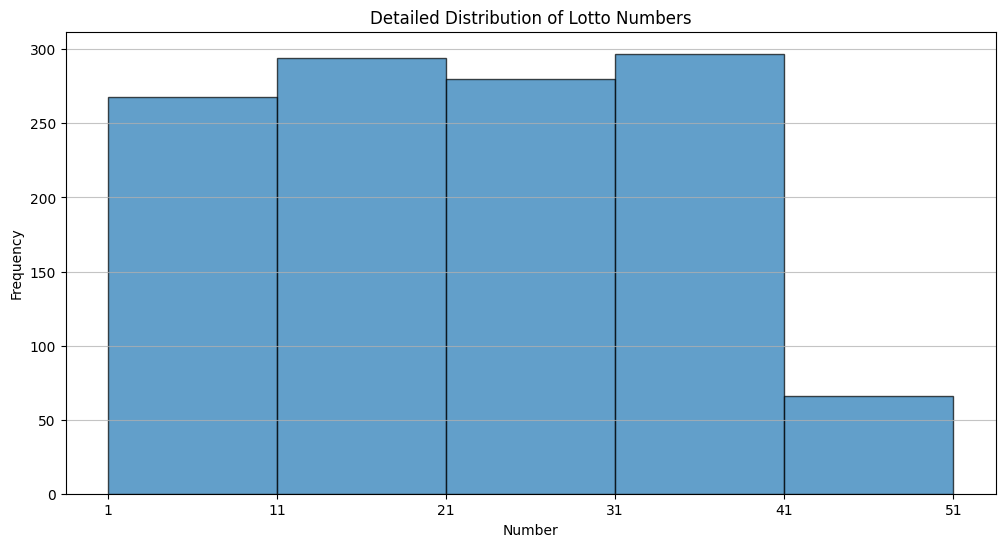

Range: 31-40, Frequency: 297
Range: 11-20, Frequency: 294
Range: 21-30, Frequency: 280
Range: 1-10, Frequency: 268
Range: 41-50, Frequency: 66


In [109]:
def plot_number_distribution(lotto_data, bin_size=10):
    """
    Plots the distribution of lotto numbers with more detailed x-axis.

    :param lotto_data: Dictionary of lotto results.
    :param bin_size: Size of each bin in the histogram, default is 1 for finer detail.
    """
    all_numbers = []
    for play_data in lotto_data.values():
        all_numbers.extend(play_data['numbers'])

    # Determine the range of numbers
    min_number = min(all_numbers)
    max_number = max(all_numbers)

    # Create a histogram to visualize the distribution
    plt.figure(figsize=(12, 6))
    counts, bins, patches = plt.hist(all_numbers, bins=range(min_number, max_number + bin_size, bin_size), edgecolor='black', alpha=0.7)

    # Adjust the x-axis to cover the entire range of bins
    plt.xticks(range(min_number, max_number + bin_size, bin_size))

    plt.xlabel('Number')
    plt.ylabel('Frequency')
    plt.title('Detailed Distribution of Lotto Numbers')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

    # Sorting and printing bin frequencies from highest to lowest
    bin_frequencies = Counter({f'{int(bins[i])}-{int(bins[i+1])-1}': int(counts[i]) for i in range(len(counts))})
    for bin_range, frequency in bin_frequencies.most_common():
        print(f"Range: {bin_range}, Frequency: {frequency}")

# Example usage
plot_number_distribution(lotto_results)